In [71]:
import pandas as pd
import numpy as np
import os
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from fancyimpute import KNN,SoftImpute
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline 

In [72]:
!pip install fancyimpute
from fancyimpute import KNN,SoftImpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Test data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    '''print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))'''
    
    return est, y1, y2[:, 1]

#Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = metrics.confusion_matrix(y_test, y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix, plt

In [74]:
#############Reading the dataset############################
#my_change
#data=pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/358/LoansTrainingSetV2.csv",low_memory=True)
data=pd.read_csv('LoansTrainingSetV2.csv')

###############EDA Starts here####################################
data.head()
len(data)

##Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
data = pd.concat([data[0:100], data[-100:]], axis=0)

In [76]:
data.describe()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens
count,200.000000,200.000000,200.00000,200.000000,90.000000,200.00000,200.000000,200.00000,199.000000,200.000000
mean,14824.395000,3882.340000,65256.73500,17.971500,30.088889,10.78500,0.200000,15155.21500,0.105528,0.085000
std,7700.841182,3183.307945,31614.96858,7.096304,22.151493,4.67741,0.634043,22227.33479,0.308007,0.488845
min,2194.000000,614.000000,11469.00000,6.200000,1.000000,2.00000,0.000000,0.00000,0.000000,0.000000
25%,9185.000000,726.000000,44555.00000,13.400000,12.000000,7.00000,0.000000,5854.75000,0.000000,0.000000
50%,14215.000000,3425.500000,58827.00000,16.700000,27.000000,10.00000,0.000000,10915.00000,0.000000,0.000000
75%,19272.250000,7160.000000,80663.25000,21.250000,41.000000,13.00000,0.000000,17635.50000,0.000000,0.000000
max,35592.000000,7500.000000,225653.00000,49.300000,81.000000,28.00000,6.000000,275876.00000,1.000000,5.000000


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


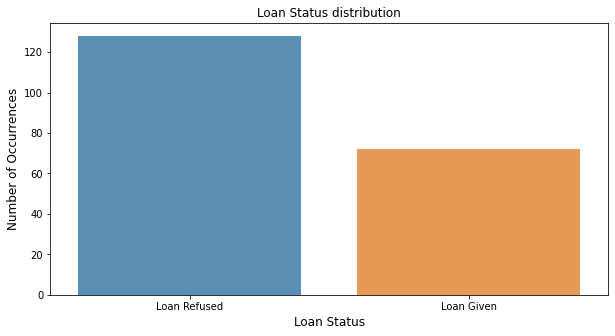

In [77]:
##########PLotting the loan status 
status=data["Loan Status"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()
##########################

10087.25


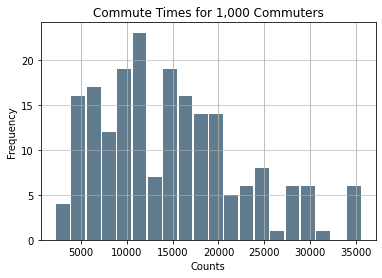

In [78]:
###########Now we will go over column by column to fix the data #################


###Current Loan Amount ############
data["Current Loan Amount"].describe()


data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)


data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]


temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()


#temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
#temp.plot.hist(grid=True, bins=20, rwidth=0.9,
#                   color='#607c8e')


temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(float)
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

#int(float('55063.000000'))
                   
temp.describe()

#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


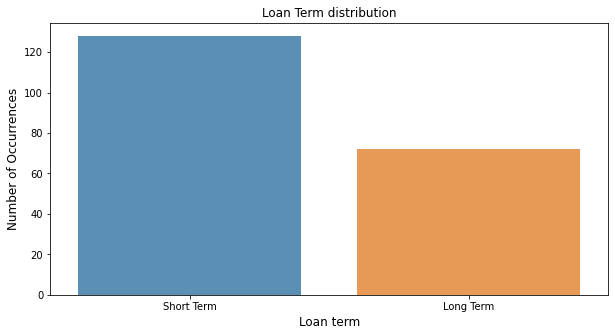

In [79]:
############Term ##############

status=data["Term"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

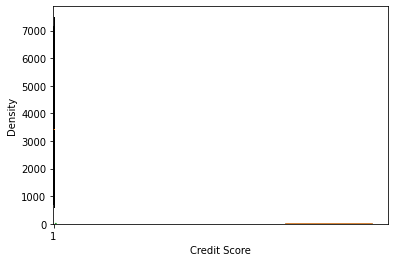

In [80]:
#####Credit Score#############

data["Credit Score"].describe()
##Max is 7510. It should be between 0-800
plt.boxplot(data["Credit Score"])

data["Credit Score"].isnull().unique()

#Shows there are missing values in the data

#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])

#Now lets replace the missing values with median 
median_score=statistics.median(data["Credit Score"])

data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

sns.distplot(data["Credit Score_1"])
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution


data["Credit Score"].fillna(741, inplace = True) 

sns.distplot(data["Credit Score"])
sns.distplot(np.log(data["Credit Score"]))

In [81]:
########Years in current job #######



#######################################

data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. Lets fix that

data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()

##################Annual Income######################
data['Annual Income'].describe()

##Lets look at the quantiles of this columns

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])

##0.200     40764.00
##0.750     86750.25
##0.900    119916.00
##0.950    147645.00
##0.990    239286.96
##0.999    491575.77

#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end

0

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

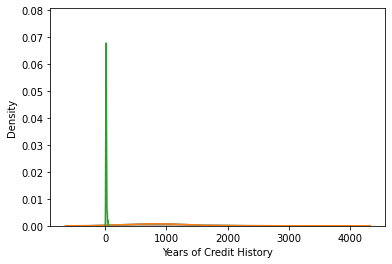

In [82]:
###############Loan Purpose ###############

data['Purpose'].value_counts()
#So other and Other mean the same thing. Lets make it the same

data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)


#######Monthly debt ###############


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float

#my_change-commented next line
#pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it 
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])

#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here

data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])

#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile

data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330

data['Monthly Debt'].quantile([0.999,1])
#0.999     4926.37475
#1.000    22939.12000
#Need to replace this


data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])

#Now we get the right distribution


####################Years of credit history #################

data['Years of Credit History'].value_counts()


sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

array([0., 1., 3.])

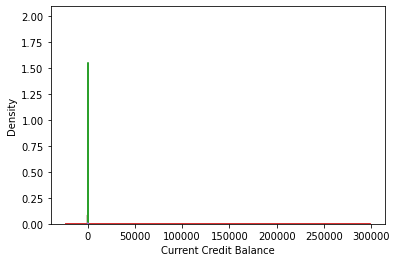

In [83]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()

#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last 


##############Number of open accounts ##############

data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate


sns.distplot(data['Number of Open Accounts'])
#Yes there are outliers in this columns. Let dig deeper


data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values


data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36


sns.distplot(data['Number of Open Accounts'])
#Looks good now


#######################Number of Credit problems##############

data['Number of Credit Problems'].describe() 
#Max looks a bit higher. Lets see

sns.distplot(data['Number of Credit Problems'])
#Okay lets look at value _counts


data['Number of Credit Problems'].value_counts()

#Okay looks good


##################Current Credit Balance###########

data['Current Credit Balance'].describe()

sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate

data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])

#0.750      19301.000
#0.950      39933.300
#0.999     227670.033
#1.000    1730472.000

#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


#So lets replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])




data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007


sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. We need to transform it

data['Current Credit Balance']=data['Current Credit Balance']**(1/2)

#######################Max open credit################

data['Maximum Open Credit'].describe()

data['Maximum Open Credit'].value_counts()

#my_change - commenting next line and pd.to_numeric..
#sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them

#pd.to_numeric(data['Maximum Open Credit'])

#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
    
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])


data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])

#Lets replace the outliers


data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423

#Looks much better now

###############Bankruptcies##########
data['Bankruptcies'].describe()

data['Bankruptcies'].value_counts()

data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median

data['Bankruptcies']=data['Bankruptcies'].fillna(3)
#Looks good

####Tax Liens######

data['Tax Liens'].describe()

data['Tax Liens'].value_counts()

data['Bankruptcies'].unique()


###Looks good

In [84]:
data['Loan Status'].head(4)

0    Loan Refused
1    Loan Refused
2    Loan Refused
3    Loan Refused
Name: Loan Status, dtype: object

In [85]:
################Now we will impute missing values to the columns which have NA's ####################

###Converting all the categorical columns into numbers

cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)

#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)
#df_LC['Loan_Status']=data['Loan Status']


#Binarizing the Target variable
#lb_style = LabelBinarizer()
#lb_results = lb_style.fit_transform(data['Loan Status'])
#y=lb_results
#y=y.ravel()


#Binarizing the Target variable

from sklearn import preprocessing
lb_style = preprocessing.LabelBinarizer()
data['Loan Status'] = data['Loan Status'].astype(str)
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(data)
#print(X_scaled)
#print('   ')
#print(X_scaled.shape)

[SoftImpute] Max Singular Value of X_init = 1110388.155407
[SoftImpute] Iter 1: observed MAE=262.854718 rank=3
[SoftImpute] Iter 2: observed MAE=258.891358 rank=3
[SoftImpute] Iter 3: observed MAE=257.610095 rank=3
[SoftImpute] Iter 4: observed MAE=257.187545 rank=3
[SoftImpute] Iter 5: observed MAE=257.014722 rank=3
[SoftImpute] Iter 6: observed MAE=256.955629 rank=3
[SoftImpute] Iter 7: observed MAE=256.930516 rank=3
[SoftImpute] Iter 8: observed MAE=256.920687 rank=3
[SoftImpute] Iter 9: observed MAE=256.915815 rank=3
[SoftImpute] Iter 10: observed MAE=256.913157 rank=3
[SoftImpute] Iter 11: observed MAE=256.911813 rank=3
[SoftImpute] Iter 12: observed MAE=256.911169 rank=3
[SoftImpute] Stopped after iteration 12 for lambda=22207.763108


ValueError: ignored

In [87]:
np.bincount(y)

array([ 72, 128])

In [86]:
type(X_scaled)


numpy.ndarray

[0.08312143 0.04942401 0.10702202 0.09409108 0.04297861 0.0589921
 0.07209346 0.07402141 0.08464415 0.06381991 0.08424216 0.07152457
 0.05546716 0.05855793 0.         0.        ]


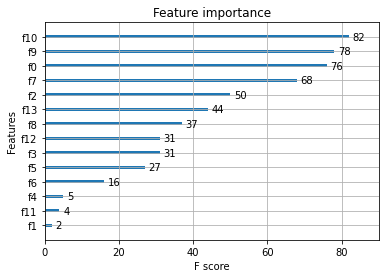

In [88]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)


print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)

## Login to TrueFoundry  🎉

1. An account with  <a href="https://projectpro.truefoundry.com/signin">TrueFoundry</a>. has been created with the same email address that you use to sign in to ProjectPro and an email has been sent to you to set your password. 
2. Please go to your inbox and follow the link to make sure you are logged into TrueFoundry before getting to the next cell. If you don't see the email in your inbox, please check your Spam folder. 

Note: If you are not able to signin or did not receive an email, please send an email to nikunj@truefoundry.com with the following subject- "ProjectPro User: TrueFoundry Login Issue"

In [89]:
!pip install mlfoundry --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 124 kB 13.7 MB/s 
     |████████████████████████████████| 29.4 MB 55.9 MB/s 
     |████████████████████████████████| 2.1 MB 74.3 MB/s 
     |████████████████████████████████| 182 kB 47.3 MB/s 
     |████████████████████████████████| 280 kB 59.0 MB/s 
     |████████████████████████████████| 132 kB 63.2 MB/s 
     |████████████████████████████████| 3.4 MB 42.5 MB/s 
     |████████████████████████████████| 96 kB 4.6 MB/s 
     |████████████████████████████████| 1.3 MB 80.8 MB/s 
     |████████████████████████████████| 82 kB 521 kB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 10.2 MB 57.1 MB/s 
     |████████████████████████████████| 140 kB 67.1 MB/s 
     |████████████████████████████████| 2.0 MB 45.3 MB/s 
     |████████████████████████████████| 59 kB 345 kB/s 
     |███████████████████████████████

In [2]:
!pip install mlfoundry
import mlfoundry as mlf

TRACKING_URL = 'https://projectpro.truefoundry.com'

mlf_api = mlf.get_client(TRACKING_URL)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[mlfoundry] 2022-12-09T07:36:03+0000 WARNING Passing `tracking_uri` is not supported anymore.
Use `mlfoundry login --tracking_uri https://projectpro.truefoundry.com` command or `mlfoundry.login(https://projectpro.truefoundry.com)` function call to login and set tracking uri
[mlfoundry] 2022-12-09T07:36:03+0000 WARNING Amplitude client is not initialised, please call `init` first


MlFoundryException: ignored

In [3]:
mlf_run = mlf_api.create_run(project_name='loan-eligibility-prediction', run_name="XGB-regressor")

mlf_run.log_model(xgb0, mlf.ModelFramework.SKLEARN)
mlf_run.log_params(xgb0.get_params())

metrics_dict = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_b),
    'f1-score': metrics.f1_score(y_test, y_pred_b),    
}
mlf_run.log_metrics(metrics_dict)

mlf_run.log_dataset(
    dataset_name = 'test',
    features = X_test,
    predictions = y_pred_b,
    actuals = y_test,
)

mlf_run.log_plots({"Feature-Importance": pyplot}, step=1)


NameError: ignored

In [4]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)

########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)



#########Running on unbalanced dataset #############

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix, plt = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')


models_report

mlf_run = mlf_api.create_run(project_name='loan-eligibility-prediction', run_name="balanced-data-models")
metrics_names = ["matthews_corrcoef", "roc_auc_score", "precision_score", "recall_score", "f1_score"]

metrics_dict = {}
plot_dict = {}
for model in models_report["model"]:
    for metric in metrics_names:
        metrics_dict[f"{model}-{metric}"] = models_report[models_report["model"]==model][metric].values[0]
    disp = metrics.ConfusionMatrixDisplay(conf_matrix[model])
    disp.plot()
    plot_dict[f"{model}-confusion-matrix"] = plt

mlf_run.log_metrics(metrics_dict)

mlf_run.log_plots({"ROC-curve": plt}, step=1)
mlf_run.log_plots(plot_dict, step=1)


NameError: ignored

In [5]:
###########Synthetically balancing the dataset##################


index_split = int(19*len(X_scaled)/20)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

models_report_bal, conf_matrix_bal, plt = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')


################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
#joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

NameError: ignored

In [6]:
mlf_run = mlf_api.create_run(project_name='loan-eligibility-prediction', run_name="GradientBoostingClassifier")

mlf_run.log_model(gbm, mlf.ModelFramework.SKLEARN)
mlf_run.log_params(gbm.get_params())

y_pred = gbm.predict(X_scaled)

metrics_dict = {
    'accuracy': metrics.accuracy_score(y, y_pred),
    'f1-score': metrics.f1_score(y, y_pred),    
}
mlf_run.log_metrics(metrics_dict)

mlf_run.log_dataset(
    dataset_name = 'test',
    features = X_scaled,
    predictions = y_pred,
    actuals = y,
)

y_score = gbm.predict_proba(X_scaled)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
plt.figure(1, figsize=(6,6))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.plot(fpr, tpr )
mlf_run.log_plots({"ROC-curve": plt}, step=1)

conf_matrix = metrics.confusion_matrix(y_pred, y)
disp = metrics.ConfusionMatrixDisplay(conf_matrix)
disp.plot()
mlf_run.log_plots({"Confusion-matrix": plt}, step=1)
plt.show()

NameError: ignored